In [6]:
import os
from typing import List
from pydantic import BaseModel
from langchain.chat_models import init_chat_model
from langchain.schema import Document
from langchain.vectorstores import FAISS
from langchain_community.document_loaders.youtube import YoutubeLoader
from langchain_community.document_loaders import TextLoader,ArxivLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.utilities import WikipediaAPIWrapper
from langgraph.graph import StateGraph,END
from langchain_openai import OpenAIEmbeddings
from langchain.tools import WikipediaQueryRun

In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

llm=init_chat_model('groq:gemma2-9b-it')

In [19]:
def load_text_retriever(file_path):
    docs=TextLoader(file_path,encoding='utf-8').load()
    splitter=RecursiveCharacterTextSplitter(chunk_size=500,chunk_overlap=50)
    chunks=splitter.split_documents(docs)
    vector_store=FAISS.from_documents(chunks,OpenAIEmbeddings(model='text-embedding-3-small'))
    return vector_store.as_retriever()

In [20]:
def load_youtube_retriever():
    content="""
This video explains how agentic AI System rely on feedback loops,memory and tool use.
It Compares them to traditional pipeline-base LLMs.Temporal reasoning and autonomous tasking are emphasized."""
    doc=Document(page_content=content,metadata={'source':'youtube'})
    vector_store=FAISS.from_documents([doc],OpenAIEmbeddings(model='text-embedding-3-small'))
    return vector_store.as_retriever()

In [21]:
def wikipedia_search(query:str) -> str:
    print("Searching Wikipedia...")
    return WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())(query)

def arxiv_search(query:str) -> str:
    print("Searching arxiv...")
    results=ArxivLoader(query).load()
    return "\n\n".join(doc.page_content for doc in results[:2]) or "No relevant papers found"

In [22]:
text_retriever=load_text_retriever('research_notes.txt')
youtube_retriever=load_youtube_retriever()

In [23]:
class MultiSourceRAGState(BaseModel):
    question:str
    text_docs:List[Document]=[]
    yt_docs:List[Document]=[]
    wiki_context:str=""
    arxiv_context:str=""
    final_answer:str=""

In [24]:
def retrieve_text(state:MultiSourceRAGState)->MultiSourceRAGState:
    docs=text_retriever.invoke(state.question)
    return state.model_copy(update={'text_docs':docs})

def retrieve_yt(state:MultiSourceRAGState) -> MultiSourceRAGState:
    docs=youtube_retriever.invoke(state.question)
    return state.model_copy(update={'yt_docs':docs})

def retrieve_wikipedia(state:MultiSourceRAGState)->MultiSourceRAGState:
    result=wikipedia_search(state.question)
    return state.model_copy(update={'wiki_context':result})

def retrieve_arxiv(state:MultiSourceRAGState) -> MultiSourceRAGState:
    result=arxiv_search(state.question)
    return state.model_copy(update={'arxiv_context':result})

In [25]:
def synthesize_answer(state:MultiSourceRAGState) -> MultiSourceRAGState:
    context=""
    context+="\n\n[Internal Docs]\n" + "\n".join([doc.page_content for doc in state.text_docs])
    context+="\n\n[Youtube Transcript]\n" + "\n".join([doc.page_content for doc in state.yt_docs])
    context+="\n\n[wikipedia]\n"+state.wiki_context
    context+="\n\n[Arxiv]\n"+state.arxiv_context

    prompt=f"""You have retrieved relevant context from multiple sources.Now synthesize a complete and coherent answer.
    Question:{state.question}
    Context:{context}
    
    Final Answer:"""

    answer=llm.invoke(prompt).content.strip()
    return state.model_copy(update={'final_answer':answer})    

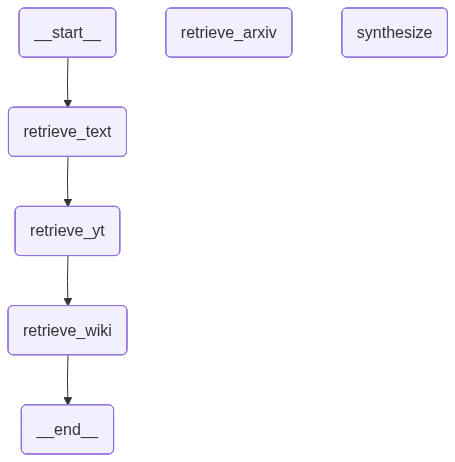

In [26]:
builder=StateGraph(MultiSourceRAGState)

builder.add_node('retrieve_text',retrieve_text)
builder.add_node('retrieve_yt',retrieve_yt)
builder.add_node('retrieve_wiki',retrieve_wikipedia)
builder.add_node('retrieve_arxiv',retrieve_arxiv)
builder.add_node('synthesize',synthesize_answer)

builder.set_entry_point('retrieve_text')
builder.add_edge('retrieve_text','retrieve_yt')
builder.add_edge('retrieve_yt','retrieve_wiki')
builder.add_edge('retrieve_arxiv','synthesize')
builder.add_edge('synthesize',END)

graph=builder.compile()
graph

In [30]:
question="attention is all you need?"
state=MultiSourceRAGState(question=question)
result=graph.invoke(state)

print("Final Answer:\n",result['final_answer'])

Searching Wikipedia...
Final Answer:
 


In [31]:
result

{'question': 'attention is all you need?',
 'text_docs': [Document(id='a20a6c97-042a-4a1d-a2a8-9935d875bf28', metadata={'source': 'research_notes.txt'}, page_content='The general-purpose nature of attention means it has become a universal primitive for intelligent systems, much like convolution was for vision in the previous era.'),
  Document(id='fe3afb0e-c75c-47c5-8ff0-4f89535d44fe', metadata={'source': 'research_notes.txt'}, page_content='story of attention is a case study not just in innovation, but in how a single concept can transform an entire field and shape the future trajectory of technology.'),
  Document(id='2bf11de5-a235-4c06-80b2-45ebceb7584b', metadata={'source': 'research_notes.txt'}, page_content='In conclusion, the attention mechanism represents a landmark case in the evolution of artificial intelligence. Its development responded to a clear technical need — capturing long-range dependencies in sequences — and its success catalyzed the creation of the Transformer, whi